# Capítulo 6: Análisis Exploratorio de Datos – Google Earth Engine

En esta _notebook_ se encuentra el procedimiento para la generación de las visualizaciones
y estadísticas de los conjuntos de datos usados para este trabajo de tesis.

***

## Librerías y funciones necesarias

### Librerías

In [1]:
# ==== Manipulación de datos y cómputo científico ==== #
import numpy as np 
import scipy
import pandas as pd

# ==== Manejo de datos vectoriales ==== #
import geopandas as gpd 

# ==== Visualización de datos ==== #
import matplotlib as mpl 
import matplotlib.pyplot as plt
plt.rcParams['axes.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rc('font', family='serif')
plt.rc('axes', axisbelow=True)
import seaborn as sns

# ==== Google Earth Engine API y apoyos ==== #
import ee 
ee.Initialize()
print("Google Earth Engine Iniciado con éxito")
import eemont
import geemap

# ==== Visualización de mapas interactivos ==== #
import folium 

Google Earth Engine Iniciado con éxito


In [2]:
# ==== Librerías extras === #
from IPython.display import HTML, Image
from pprint import pprint

### Funciones

In [3]:
# Función de visualización con Folium
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [4]:
# Cambio de temperatura
def kelvin_to_celsius(image):
    Scale = image.multiply(0.02)
    toCelsius = Scale.subtract(273.15)
    image_Celsius = toCelsius.copyProperties(image, ['system:time_start'])
    return image_Celsius

# Escalamiento de unidades
def scale_soil(image):
    scale_image = image.multiply(0.1).copyProperties(image,['system:time_start'])
    return scale_image

def scale_psdi(image):
    scale_image = image.multiply(0.01).copyProperties(image,['system:time_start'])
    return scale_image

def scale_vegIndex_modis(image):
    scale_image = image.multiply(0.0001).copyProperties(image,['system:time_start'])
    return scale_image

### Paleta de colores

In [5]:
List_palette_01 = ['#F2E8CF', '#A7C957', '#6A994E', '#386641', '#99621E', '#8C271E', '#BC4749', '#DD7373', 
'#2D3047']
List_palette_02_binary = ['#7D4E99', '#6A994E']
List_palette_03_temperature = ['#0692B1', '#05C7C0', '#62BE37', '#97D91C', '#CCF500', '#EFEF1A', '#FFC71F', 
'#FF9933', '#FF8133', '#CC0000']
List_palette_04_moisture = ['#FCCA9C','#FFDB70','#F3F353','#B7DD2C','#449933','#226A6D','#0C485A']
List_palette_05_drought = ['#F07167','#FDFCDC','#0081A7']
List_palette_06_NDVI = ['#FF7433', '#F5F5F5', '#487070']
List_palette_07_EVI = ['#A12B44', '#E4E986', '#238031']
List_palette_08_Anomalies_VegIdx = ['#3E131C', '#B42D4A', '#FFB833','#69A267','#67725A']

## Cargar datos

In [6]:
# ======= CARGAR DATOS ======= #
# Relevantes
ImgColl_Temp = ee.ImageCollection("MODIS/006/MOD11A1")
ImgColl_Climate = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
ImgColl_VegIndex = ee.ImageCollection("MODIS/006/MOD13Q1")
ImgColl_Fires = ee.ImageCollection("ESA/CCI/FireCCI/5_1")

In [7]:
# ======= CREAR FILTROS DE TIEMPO ======= #
# "20 años"
Filter_Years = ee.Filter.calendarRange(start=2001, end=2019, field='year')

In [8]:
# ======= CREAR GEOMETRÍA ======= #
yuc_info = gpd.read_file('../datos/31_yucatan/conjunto_de_datos/31ent.shp')
yuc_info = yuc_info.to_crs(4326)
roi_centroid = (yuc_info.geometry.centroid.y.values[0], yuc_info.geometry.centroid.x.values[0])
fc = geemap.geopandas_to_ee(yuc_info)
roi = fc.geometry()

/var/folders/4v/6cw09vvn5rz3f7jl4cmpxzkc0000gp/T/ipykernel_90385/3518474257.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  roi_centroid = (yuc_info.geometry.centroid.y.values[0], yuc_info.geometry.centroid.x.values[0])
/var/folders/4v/6cw09vvn5rz3f7jl4cmpxzkc0000gp/T/ipykernel_90385/3518474257.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  roi_centroid = (yuc_info.geometry.centroid.y.values[0], yuc_info.geometry.centroid.x.values[0])


In [9]:
# ======= SELECCIONAR BANDAS ======= #
ImgColl_Temp = ImgColl_Temp.select(['LST_Day_1km'])
ImgColl_Humedad = ImgColl_Climate.select(['soil'])
ImgColl_Sequia = ImgColl_Climate.select(['pdsi'])
ImgColl_Fires = ImgColl_Fires.select(['BurnDate', 'ConfidenceLevel'])
ImgColl_NDVI = ImgColl_VegIndex.select(['NDVI'])
ImgColl_EVI = ImgColl_VegIndex.select(['EVI'])

In [10]:
# ======= APLICAR FILTROS A DATOS RELEVANTES ======= #
# Temperatura
ImgColl_Temp = ImgColl_Temp.map(kelvin_to_celsius)
ImgColl_Temp = ImgColl_Temp.filter(Filter_Years)

# Humedad
ImgColl_Humedad = ImgColl_Humedad.map(scale_soil)
ImgColl_Humedad = ImgColl_Humedad.filter(Filter_Years)

# Sequia
ImgColl_Sequia = ImgColl_Sequia.map(scale_psdi)
ImgColl_Sequia = ImgColl_Sequia.filter(Filter_Years)


# Índices de vegetación
ImgColl_NDVI = ImgColl_NDVI.map(scale_vegIndex_modis)
ImgColl_NDVI = ImgColl_NDVI.filter(Filter_Years)

ImgColl_EVI = ImgColl_EVI.map(scale_vegIndex_modis)
ImgColl_EVI = ImgColl_EVI.filter(Filter_Years)


# Registro de incendios
ImgColl_Fires = ImgColl_Fires.filter(Filter_Years)


## Registro de incendios forestales

El conjunto de datos con la información mensual de los incendios forestales es el 
[MODIS Fire_cci Burned Area pixel product version 5.1 (FireCCI51)](https://developers.google.com/earth-engine/datasets/catalog/ESA_CCI_FireCCI_5_1)
a diferencia del conjunto de datos de FIRMS, la información se limita a registros desde el año 2001 hasta el año 2019.

Un atributo que comparte el conjunto de GEE y FIRMS es la el nivel de confianza de un determinado incendio, por lo que se aplicará el mismo 
filtro únicamente la identificación de valores arriba del 84% de nivel de confianza.

In [11]:
# Función para filtro por nivel de confianza
def f_filtro_confianza(image):
    confianza = image.select('ConfidenceLevel')
    # gt(number) -> greater than (num)
    mascara = confianza.gt(84)
    # Aplicamos la máscara
    final = image.updateMask(mascara)
    # Seleccionamos la banda de interés
    final = final.select('BurnDate')
    # Volvemos todos los valores 1
    final = final.gt(0)
    final = final.copyProperties(image,['system:time_start'])
    return final

In [12]:
# Aplicar la función a todas las colecciones
ImgColl_Fires = ImgColl_Fires.map(f_filtro_confianza)

> Para poder visualizar una `ee.ImageCollection` con **Folium** y la función adaptada a la operación se hacen 2 opearciones:
>
> 1. Aplicar la función `mosaic()` para que todas las  `ee.Image` se "apilen y sean una sola imagen"
> 2. Aplicar la función `clip()` y dentro de esa función poner la `ee.Geometry` a la que queramos que la `ee.Image` tome forma

In [13]:
Img_Fires_allMonths_allYears = ImgColl_Fires.mosaic().clip(roi)

In [14]:
# Se declaran los parámetros de visualización
VisParams_Fires = dict(palette=List_palette_01[8])

In [15]:
Mapa_Fires = folium.Map(location=roi_centroid, zoom_start=8, zoom_control=True)

Mapa_Fires.add_ee_layer(ee_image_object=Img_Fires_allMonths_allYears,
                        vis_params=VisParams_Fires,
                        name='Incendios del 2001-2019')

Mapa_Fires.add_child(folium.LayerControl())
Mapa_Fires


## Variables ambientales 

En anteriores conjuntos de datos se pudo obtener la temperatura de los puntos de calor pero no se tiene acceso a las 
condiciones ambientas de la superficie terrestre tales como humedad del suelo, temperatura o nivel de sequía.

Para este caso se usan los siguientes conjuntos de datos:

* Temperatura: [MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km](https://developers.google.com/earth-engine/datasets/catalog/MODIS_006_MOD11A1)
* Humedad y sequía [TerraClimate: Monthly Climate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idaho](https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE)

### Mapas

> Para obtener las estadísticas del las `ee.ImageCollection` se tienen que reducir primero a `ee.Image` a través de alguna
métrica estadística, tal como la media, mediana, etc. 
>
> Cuando se tiene la `ee.Image` es entonces cuando se obtienen las métricas de la imagen con ayuda de `.reduceRegion`
>
> Se calcula la mediana ya que es un estimador robusto a los datos anómalos

In [16]:
# Calcular la media de la mediana de los rangos de tiempo en la geometría de Yucatán
Img_Temp_allMonths_allYears = ImgColl_Temp.median().clip(roi)
Img_Humedad_allMonths_allYears = ImgColl_Humedad.median().clip(roi)
Img_Sequia_allMonths_allYears = ImgColl_Sequia.median().clip(roi)


In [17]:
# Calcular métricas estadísticas para la visualización
def f_dict_mean_std(image, region_of_interest, scale, maxPixels=1e9):
    """Esta función regresa un diccionario con la media y desviación estándar de un `ee.Image`
    
    * `image` es el objeto `ee.Image`
    * `region_of_interest` es un objeto `ee.Geometry`
    * `scale` es la escala en metros del `ee.Image` a reducir 
    * `maxPixels` es el número máximo de pixeles a computar. Por defecto es 1e9
    
    """
   
    Dict_stats = dict()
    Dict_stats['mean'] = list(image.reduceRegion(**{'reducer':ee.Reducer.mean(),
                                               'geometry':region_of_interest,
                                               'scale':scale,
                                               'maxPixels': maxPixels}).getInfo().values())[0]

    Dict_stats['std'] = list(image.reduceRegion(**{'reducer':ee.Reducer.stdDev(),
                                               'geometry':region_of_interest,
                                                'scale':scale,
                                               'maxPixels': maxPixels}).getInfo().values())[0]
    
    return Dict_stats

def f_dict_max_min(image, region_of_interest, scale, maxPixels=1e9):
    """Esta función regresa un diccionario con el minimo y máximo de un `ee.Image`
    
    * `image` es el objeto `ee.Image`
    * `region_of_interest` es un objeto `ee.Geometry`
    * `scale` es la escala en metros del `ee.Image` a reducir 
    * `maxPixels` es el número máximo de pixeles a computar. Por defecto es 1e9
    
    """
    
    Dict_stats = dict()
    Dict_stats['max_value'] = list(image.reduceRegion(**{'reducer':ee.Reducer.max(),
                                               'geometry':region_of_interest,
                                               'scale':scale,
                                               'maxPixels': maxPixels}).getInfo().values())[0]

    Dict_stats['min_value'] = list(image.reduceRegion(**{'reducer':ee.Reducer.min(),
                                               'geometry':region_of_interest,
                                               'scale':scale,
                                               'maxPixels': maxPixels}).getInfo().values())[0]
    return Dict_stats
    

In [18]:
# ADVERTENCIA: Esta celda de código puede tardar varios minutos

# Temperatura
dict_temp_mean_std_allM_allY = f_dict_mean_std(image=Img_Temp_allMonths_allYears,
                                               region_of_interest=roi,
                                               scale=1000)
dict_temp_max_min_allM_allY = f_dict_max_min(image=Img_Temp_allMonths_allYears,
                                               region_of_interest=roi,
                                               scale=1000)

# Humedad
dict_humedad_mean_std_allM_allY = f_dict_mean_std(image=Img_Humedad_allMonths_allYears,
                                                  region_of_interest=roi,
                                                  scale=1000)
dict_humedad_max_min_allM_allY = f_dict_max_min(image=Img_Humedad_allMonths_allYears,
                                                  region_of_interest=roi,
                                                  scale=1000)

# Sequia
dict_sequia_mean_std_allM_allY = f_dict_mean_std(image=Img_Sequia_allMonths_allYears,
                                                 region_of_interest=roi,
                                                 scale=1000)
dict_sequia_max_min_allM_allY = f_dict_max_min(image=Img_Sequia_allMonths_allYears,
                                                 region_of_interest=roi,
                                                 scale=1000)

In [20]:
print('Métricas de temperatura en el periodo de tiempo del 2001 al 2019:')
print("")
for key in dict_temp_mean_std_allM_allY:
    print(f'{key}: {round(dict_temp_mean_std_allM_allY[key],3)} ˚C')
for key in dict_temp_max_min_allM_allY:
    print(f'{key}: {round(dict_temp_max_min_allM_allY[key],3)} ˚C')

print('\n\nMétricas de humedad en el periodo de tiempo del 2001 al 2019:')
print("")
for key in dict_humedad_mean_std_allM_allY:
    print(f'{key}: {round(dict_humedad_mean_std_allM_allY[key],3)} mm')
for key in dict_humedad_max_min_allM_allY:
    print(f'{key}: {round(dict_humedad_max_min_allM_allY[key],3)} mm')

print('\n\nMétricas de sequia en el periodo de tiempo del 2001 al 2019:')
print("")
for key in dict_sequia_mean_std_allM_allY:
    print(f'{key}: {round(dict_sequia_mean_std_allM_allY[key],3)}')
for key in dict_sequia_max_min_allM_allY:
    print(f'{key}: {round(dict_sequia_max_min_allM_allY[key],3)}')

Métricas de temperatura en el periodo de tiempo del 2001 al 2019:

mean: 29.384 ˚C
std: 1.091 ˚C
max_value: 35.688 ˚C
min_value: 25.25 ˚C


Métricas de humedad en el periodo de tiempo del 2001 al 2019:

mean: 60.646 mm
std: 51.162 mm
max_value: 280.85 mm
min_value: 0.7 mm


Métricas de sequia en el periodo de tiempo del 2001 al 2019:

mean: 1.155
std: 0.169
max_value: 1.576
min_value: -2.404


In [21]:
# MAPA DE VARIABLES AMBIENTALES
# Crear mapa
Map_environment_01 = folium.Map(location=roi_centroid, zoom_start=8, zoom_control=True)

# Parámetros de visualización
VisParams_Temp = dict(palette=List_palette_03_temperature, min=25, max=35)
VisParams_Hum  = dict(palette=List_palette_04_moisture, min = 1, max=280)
VisParams_Seq  = dict(palette=List_palette_05_drought, min=-4, max=4) 
# Agregar capas a mapa
Map_environment_01.add_ee_layer(ee_image_object=Img_Temp_allMonths_allYears,
                            vis_params= VisParams_Temp,
                            name='Temperatura media (˚C)  (2001-2020)')
Map_environment_01.add_ee_layer(ee_image_object=Img_Humedad_allMonths_allYears,
                            vis_params= VisParams_Hum,
                            name='Humedad media (mm) (2001-2020)')
Map_environment_01.add_ee_layer(ee_image_object=Img_Sequia_allMonths_allYears,
                            vis_params= VisParams_Seq,
                            name= 'PDSI medio (2001-2020)')
Map_environment_01.add_ee_layer(ee_image_object=Img_Fires_allMonths_allYears,
                            vis_params= VisParams_Fires,
                            name='Incendios 2001-2019')

# Control de capas
Map_environment_01.add_child(folium.LayerControl())
# Visualizar mapa
Map_environment_01

### Cambios a través del tiempo

> Obtener una serie de tiempo para 20 años es muy complicado, por lo que la información tiene que ser obtenida por partes. 
Una menera es dividir la `ee.ImageCollection` en rangos de 10 años y después concatenarlos.
>
> Tras la concanetación se hacen unos cambios para darle _formato_ al `pandas.DataFrame`. De esta manera, todos los 
`pandas.DataFrame` de las series de tiempo tendrán la misma estructura.

In [22]:
def f_time_series_p1_p2_years_mean(image_collection, list_tuples_time, dict_ts_region):
    """
    Función encargada de "dividir en 2 partes" la información para la serie de tiempo 
    de un `ee.ImageCollection`

    * `image_collection`: `ee.ImageCollection` a obtener la serie de tiempo
    * `list_tuples_time`: Lista de tuplas de (strings) periodos de tiempo 
    de inicio y final. Estructura: **`[(begin_time_1, end_time_1), (begin_time_2, end_time_2)]`**.
    * `dict_ts_region`: Diccionario de parámetros para .getTimeSeriesByRegion
    """
    def f_dataframe_format_time_series(dataframe, data_frame_naVals):
        """
        Se hacen cambios en el formato de la estructura del `pandas.DataFrame` 
        de la serie de tiempo y se agregan otras variables (tal como mes y año de la observación)
        """
        # Eliminar datos nulos 
        dataframe = dataframe[ dataframe[dict_ts_region['bands']] != data_frame_naVals]
        # Transformar columna de tiempo a formato de tiempo
        dataframe['date'] = pd.to_datetime(dataframe['date'])
        # Poner como índice
        dataframe = dataframe.set_index('date')
        # Crear columnas del mes y año de la instancia
        dataframe.loc[:,'Month'] = dataframe.index.month
        dataframe.loc[:,'Year'] = dataframe.index.year
        # Eliminar la columna del reductor
        dataframe = dataframe.drop(columns='reducer')
        return dataframe
    
    tuple_time_1, tuple_time_2 = list_tuples_time
    collection_p1 = image_collection.filterDate(tuple_time_1[0], tuple_time_1[1])
    collection_p2 = image_collection.filterDate(tuple_time_2[0], tuple_time_2[1])
    feature_coll_time_series_p1 = collection_p1.getTimeSeriesByRegion(**dict_ts_region)
    feature_coll_time_series_p2 = collection_p2.getTimeSeriesByRegion(**dict_ts_region)
    df_1 = geemap.ee_to_pandas(feature_coll_time_series_p1)
    df_2 = geemap.ee_to_pandas(feature_coll_time_series_p2)
    df = pd.concat((df_1,df_2))
    df = f_dataframe_format_time_series(dataframe=df, data_frame_naVals=dict_ts_region['naValue'])
    return df
    

In [23]:
# ADVERTENCIA: Esta celda puede tomar varios minutos en ejecutarse

# Lista de tuplas de tiempo
list_times = [('2001-01-01','2010-12-31'),('2011-01-01','2019-12-31')] 

# Diccionarios para getTimeSeriesByRegion
dict_ts_temp_allMonths_allYears = dict(reducer=ee.Reducer.mean(), geometry=roi, 
                            scale=1000, bands='LST_Day_1km', naValue=-9999)
dict_ts_humedad_allMonths_allYears = dict(reducer=ee.Reducer.mean(), geometry=roi, 
                               scale=1000, bands='soil', naValue=-9999)
dict_ts_sequia_allMonths_allYears = dict(reducer=ee.Reducer.mean(), geometry=roi, 
                              scale=1000, bands='pdsi', naValue=-9999)
# Obtener dataframes de series de tiempo
df_ts_temp_allMonths_allYears = f_time_series_p1_p2_years_mean(image_collection= ImgColl_Temp,
                                                    list_tuples_time=list_times,
                                                    dict_ts_region=dict_ts_temp_allMonths_allYears)
df_ts_temp_allMonths_allYears = df_ts_temp_allMonths_allYears.rename(columns={'LST_Day_1km':'Temperatura'})

df_ts_humedad_allMonths_allYears = f_time_series_p1_p2_years_mean(image_collection=ImgColl_Humedad,
                                                    list_tuples_time=list_times,
                                                    dict_ts_region= dict_ts_humedad_allMonths_allYears)
df_ts_humedad_allMonths_allYears = df_ts_humedad_allMonths_allYears.rename(columns={'soil':'Humedad del suelo'})

df_ts_sequia_allMonths_allYears = f_time_series_p1_p2_years_mean(image_collection=ImgColl_Sequia,
                                                    list_tuples_time=list_times,
                                                    dict_ts_region= dict_ts_sequia_allMonths_allYears)

/var/folders/4v/6cw09vvn5rz3f7jl4cmpxzkc0000gp/T/ipykernel_90385/2863612875.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['date'] = pd.to_datetime(dataframe['date'])


Text(0.08, -0.4, 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly Climate and Climatic Water\nBalance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine')

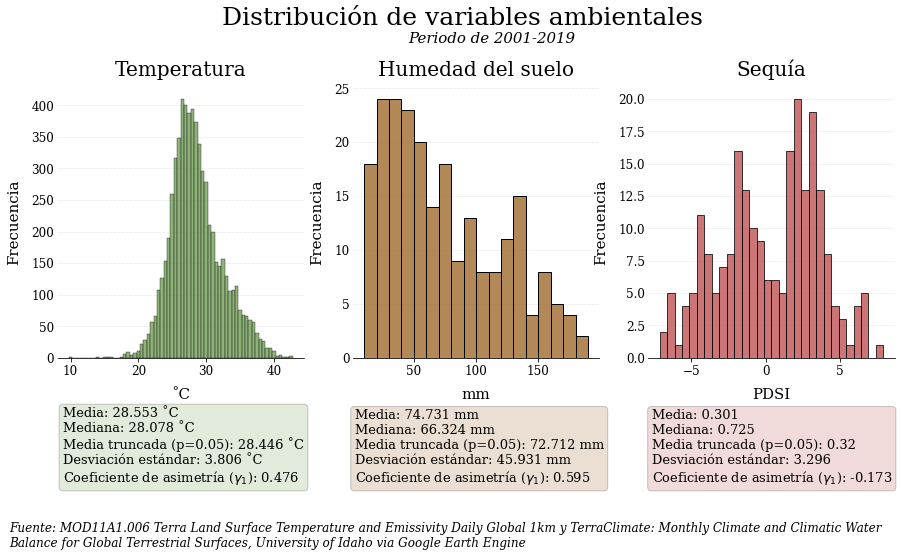

In [24]:
# Distribuciones
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3,figsize=(15,5),
#dpi=150
)

sns.histplot(data=df_ts_temp_allMonths_allYears, x='Temperatura', ax=ax1, binwidth=0.5, color=List_palette_01[2])
sns.histplot(data=df_ts_humedad_allMonths_allYears, x='Humedad del suelo', ax=ax2, binwidth=10, color=List_palette_01[4])
sns.histplot(data=df_ts_sequia_allMonths_allYears, x='pdsi', ax=ax3, binwidth=0.5, color=List_palette_01[6])

bbox_temp_metrics = dict(boxstyle='round', facecolor=List_palette_01[2], alpha=0.2)
bbox_humedad_metrics = dict(boxstyle='round', facecolor=List_palette_01[4], alpha=0.2)
bbox_sequia_metrics = dict(boxstyle='round', facecolor=List_palette_01[6], alpha=0.2)

# Metricas
media_temp = df_ts_temp_allMonths_allYears['Temperatura'].mean()
mediana_temp = df_ts_temp_allMonths_allYears['Temperatura'].median()
media_truncada_temp = scipy.stats.trim_mean(df_ts_temp_allMonths_allYears['Temperatura'],0.05)
std_temp = df_ts_temp_allMonths_allYears['Temperatura'].std()
asimetria_temp = scipy.stats.skew(df_ts_temp_allMonths_allYears['Temperatura'])

media_humedad = df_ts_humedad_allMonths_allYears['Humedad del suelo'].mean()
mediana_humedad = df_ts_humedad_allMonths_allYears['Humedad del suelo'].median()
media_truncada_humedad = scipy.stats.trim_mean(df_ts_humedad_allMonths_allYears['Humedad del suelo'],0.05)
std_humedad = df_ts_humedad_allMonths_allYears['Humedad del suelo'].std()
asimetria_humedad = scipy.stats.skew(df_ts_humedad_allMonths_allYears['Humedad del suelo'])

media_sequia = df_ts_sequia_allMonths_allYears['pdsi'].mean()
mediana_sequia = df_ts_sequia_allMonths_allYears['pdsi'].median()
media_truncada_sequia = scipy.stats.trim_mean(df_ts_sequia_allMonths_allYears['pdsi'],0.05)
std_sequia = df_ts_sequia_allMonths_allYears['pdsi'].std()
asimetria_sequia = scipy.stats.skew(df_ts_sequia_allMonths_allYears['pdsi'])


# Texto
text_temp_metrics = '\n'.join((
    f'Media: {round(media_temp,3)} ˚C',
    f'Mediana: {round(mediana_temp,3)} ˚C',
    f'Media truncada (p=0.05): {round(media_truncada_temp,3)} ˚C',
    f'Desviación estándar: {round( std_temp, 3)} ˚C', 
    f'Coeficiente de asimetría ($\gamma_1$): {round(asimetria_temp,3)}'
))

text_humedad_metrics = '\n'.join((
    f'Media: {round(media_humedad,3)} mm',
    f'Mediana: {round(mediana_humedad,3)} mm',
    f'Media truncada (p=0.05): {round(media_truncada_humedad,3)} mm',
    f'Desviación estándar: {round( std_humedad, 3)} mm', 
    f'Coeficiente de asimetría ($\gamma_1$): {round(asimetria_humedad,3)}'
))

text_sequia_metrics = '\n'.join((
    f'Media: {round(media_sequia,3)}',
    f'Mediana: {round(mediana_sequia,3)}',
    f'Media truncada (p=0.05): {round(media_truncada_sequia,3)}',
    f'Desviación estándar: {round( std_sequia, 3)}', 
    f'Coeficiente de asimetría ($\gamma_1$): {round(asimetria_sequia,3)}'
))


fig.suptitle('Distribución de variables ambientales',size=25,y=1.1)
fig.text(x=0.45,y=1,s='Periodo de 2001-2019',fontdict=dict(size=15, style='italic'))

ax1.set_title('Temperatura',size=20,pad=10)
ax1.set_xlabel('˚C',size=15, labelpad=10)
ax1.set_ylabel('Frecuencia', size=15,labelpad=10)
ax1.tick_params(axis='both', labelsize=12)
ax1.tick_params(axis='y', length=0)
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.grid(visible = True, axis='y', color='silver', alpha=1, ls=':', lw=0.5)

ax2.set_title('Humedad del suelo',size=20,pad=10)
ax2.set_xlabel('mm',size=15, labelpad=10)
ax2.set_ylabel('Frecuencia', size=15,labelpad=10)
ax2.tick_params(axis='both', labelsize=12)
ax2.tick_params(axis='y', length=0)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.grid(visible = True, axis='y', color='silver', alpha=1, ls=':', lw=0.5)

ax3.set_title('Sequía',size=20,pad=10)
ax3.set_xlabel('PDSI',size=15, labelpad=10)
ax3.set_ylabel('Frecuencia', size=15,labelpad=10)
ax3.tick_params(axis='both', labelsize=12)
ax3.tick_params(axis='y', length=0)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax3.grid(visible = True, axis='y', color='silver', alpha=1, ls=':', lw=0.5)

fig.text(x=0.13,y=-0.22,s=text_temp_metrics,fontdict=dict(size=13), bbox=bbox_temp_metrics)
fig.text(x=0.4,y=-0.22,s=text_humedad_metrics,fontdict=dict(size=13), bbox=bbox_humedad_metrics)
fig.text(x=0.675,y=-0.22,s=text_sequia_metrics,fontdict=dict(size=13), bbox=bbox_sequia_metrics)

caption = 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly Climate and Climatic Water\nBalance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine'
fig.text(x=0.08,y=-0.4,s=caption, fontdict=dict(size=12, style='italic'), ha='left')


In [25]:
# Se crea un data frame mensual de las variables ambientales
df_monthly_environment = pd.concat((df_ts_temp_allMonths_allYears.resample('M').mean()['Temperatura'],
                                    df_ts_humedad_allMonths_allYears.resample('M').mean()['Humedad del suelo'],
                                    df_ts_sequia_allMonths_allYears.resample('M').mean())
                                   , axis=1)

Text(0.5, 0.01, 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly\nClimate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine')

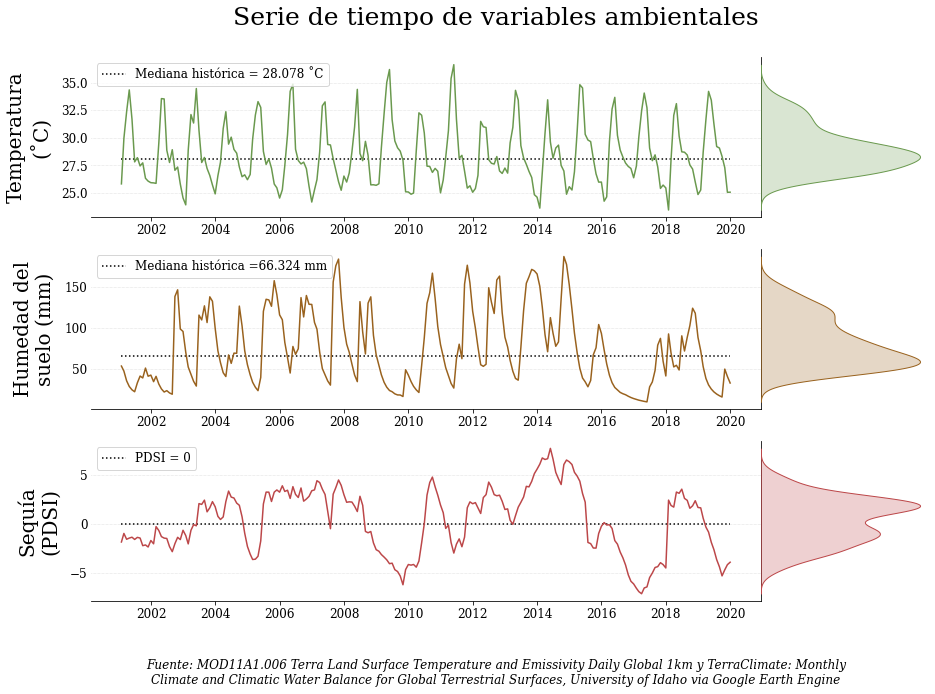

In [26]:
# Series de tiempo como líneas
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(15,10),
                                                  gridspec_kw={'width_ratios':[0.8,0.2]},
#                                                  dpi=150
                                                  )
fig.subplots_adjust(wspace=0.0)

sns.lineplot(data=df_monthly_environment, x=df_monthly_environment.index, y='Temperatura', ax=ax1, color=List_palette_01[2])
sns.kdeplot(data=df_monthly_environment, y='Temperatura', ax=ax2, fill=True, color=List_palette_01[2])
sns.lineplot(data=df_monthly_environment, x=df_monthly_environment.index, y='Humedad del suelo', ax=ax3, color=List_palette_01[4])
sns.kdeplot(data=df_monthly_environment, y='Humedad del suelo', ax=ax4, fill=True, color=List_palette_01[4])
sns.lineplot(data=df_monthly_environment, x=df_monthly_environment.index, y='pdsi', ax=ax5, color=List_palette_01[6])
sns.kdeplot(data=df_monthly_environment, y='pdsi', ax=ax6, fill=True, color=List_palette_01[6])

ax1.hlines(y=mediana_temp, xmin=df_monthly_environment.index[0], xmax=df_monthly_environment.index[-1],
colors='black', linestyle = 'dotted', label='Mediana histórica = {} ˚C'.format(round(mediana_temp,3)))
ax1.legend(loc='upper left', prop=dict(size=12))
ax3.hlines(y=mediana_humedad, xmin=df_monthly_environment.index[0], xmax=df_monthly_environment.index[-1],
colors='black', linestyle = 'dotted', label='Mediana histórica ={} mm'.format(round(mediana_humedad,3)))
ax3.legend(loc='upper left', prop=dict(size=12))
ax5.hlines(y=0, xmin=df_monthly_environment.index[0], xmax=df_monthly_environment.index[-1],
colors='black', linestyle = 'dotted', label='PDSI = 0')
ax5.legend(loc='upper left', prop=dict(size=12))


ax2.axis('off')
ax4.axis('off')
ax6.axis('off')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)

ax1.set_ylabel('Temperatura\n(˚C)', size=20, labelpad=10)
ax1.set_xlabel('')
ax1.tick_params(axis='y', length=0)
ax1.tick_params(labelsize=12)
ax1.grid(visible = True, axis='y', color='silver', alpha=1, ls=':', lw=0.5)

ax3.set_ylabel('Humedad del\nsuelo (mm)', size=20, labelpad=10)
ax3.set_xlabel('')
ax3.tick_params(axis='y', length=0)
ax3.tick_params(labelsize=12)
ax3.grid(visible = True, axis='y', color='silver', alpha=1, ls=':', lw=0.5)

ax5.set_ylabel('Sequía\n(PDSI)', size=20, labelpad=10)
ax5.set_xlabel('')
ax5.tick_params(axis='y', length=0)
ax5.tick_params(labelsize=12)
ax5.grid(visible = True, axis='y', color='silver', alpha=1, ls=':', lw=0.5)

fig.suptitle('Serie de tiempo de variables ambientales', size=25, y=0.95)

caption = 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly\nClimate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine'
fig.text(x=0.5,y=0.01,s=caption, fontdict=dict(size=12, style='italic'), ha='center')


Algo interesante a recalcar es que los periodos del inicios del 2016 a inicios del 2018 fueron los periodos más secos 
en el estado de Yucatán, así como los menos húmedos y más cálidos (con respecto a la mediana).

Text(0.5, 0.01, 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly\nClimate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine')

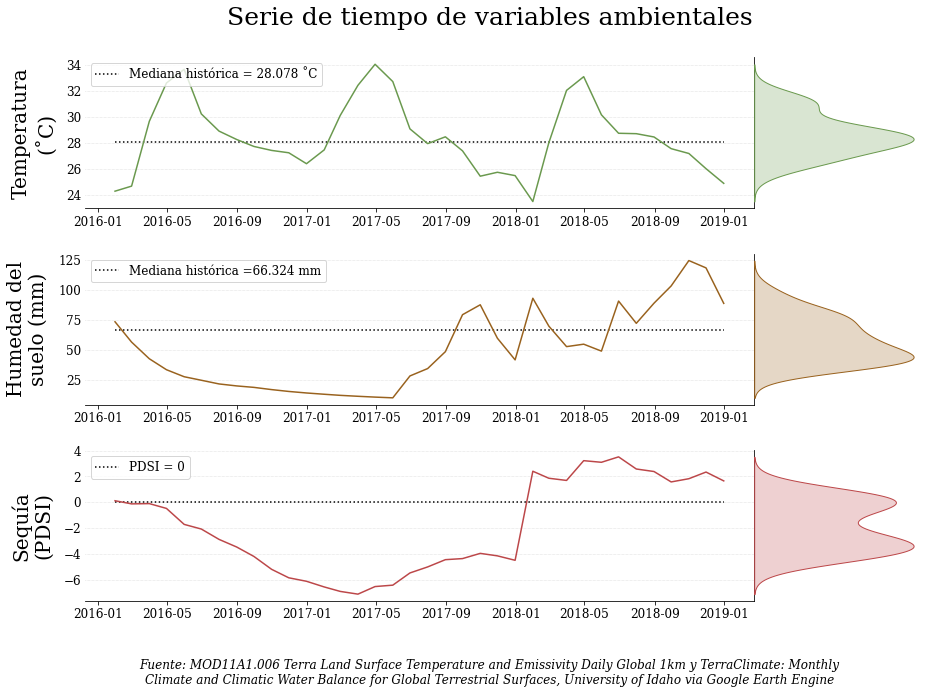

In [27]:
df_monthly_environment_2016_2018 = df_monthly_environment.loc['2016':'2018']

# Series de tiempo como líneas
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(nrows=3, ncols=2, sharex=False, figsize=(15,10),
                                                  gridspec_kw={'width_ratios':[0.8,0.2]},
#                                                  dpi=150
                                                  )
fig.subplots_adjust(wspace=0.0, hspace=0.3)

sns.lineplot(data=df_monthly_environment_2016_2018, x=df_monthly_environment_2016_2018.index, y='Temperatura', ax=ax1, color=List_palette_01[2])
sns.kdeplot(data=df_monthly_environment_2016_2018, y='Temperatura', ax=ax2, fill=True, color=List_palette_01[2])
sns.lineplot(data=df_monthly_environment_2016_2018, x=df_monthly_environment_2016_2018.index, y='Humedad del suelo', ax=ax3, color=List_palette_01[4])
sns.kdeplot(data=df_monthly_environment_2016_2018, y='Humedad del suelo', ax=ax4, fill=True, color=List_palette_01[4])
sns.lineplot(data=df_monthly_environment_2016_2018, x=df_monthly_environment_2016_2018.index, y='pdsi', ax=ax5, color=List_palette_01[6])
sns.kdeplot(data=df_monthly_environment_2016_2018, y='pdsi', ax=ax6, fill=True, color=List_palette_01[6])

ax1.hlines(y=mediana_temp, xmin=df_monthly_environment_2016_2018.index[0], xmax=df_monthly_environment_2016_2018.index[-1],
colors='black', linestyle = 'dotted', label='Mediana histórica = {} ˚C'.format(round(mediana_temp,3)))
ax1.legend(loc='upper left', prop=dict(size=12))
ax3.hlines(y=mediana_humedad, xmin=df_monthly_environment_2016_2018.index[0], xmax=df_monthly_environment_2016_2018.index[-1],
colors='black', linestyle = 'dotted', label='Mediana histórica ={} mm'.format(round(mediana_humedad,3)))
ax3.legend(loc='upper left', prop=dict(size=12))
ax5.hlines(y=0, xmin=df_monthly_environment_2016_2018.index[0], xmax=df_monthly_environment_2016_2018.index[-1],
colors='black', linestyle = 'dotted', label='PDSI = 0')
ax5.legend(loc='upper left', prop=dict(size=12))


ax2.axis('off')
ax4.axis('off')
ax6.axis('off')
ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['left'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.spines['left'].set_visible(False)

ax1.set_ylabel('Temperatura\n(˚C)', size=20, labelpad=10)
ax1.set_xlabel('')
ax1.tick_params(axis='y', length=0)
ax1.tick_params(labelsize=12)
ax1.grid(visible = True, axis='y', color='silver', alpha=1, ls=':', lw=0.5)

ax3.set_ylabel('Humedad del\nsuelo (mm)', size=20, labelpad=10)
ax3.set_xlabel('')
ax3.tick_params(axis='y', length=0)
ax3.tick_params(labelsize=12)
ax3.grid(visible = True, axis='y', color='silver', alpha=1, ls=':', lw=0.5)

ax5.set_ylabel('Sequía\n(PDSI)', size=20, labelpad=10)
ax5.set_xlabel('')
ax5.tick_params(axis='y', length=0)
ax5.tick_params(labelsize=12)
ax5.grid(visible = True, axis='y', color='silver', alpha=1, ls=':', lw=0.5)

fig.suptitle('Serie de tiempo de variables ambientales', size=25, y=0.95)

caption = 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly\nClimate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine'
fig.text(x=0.5,y=0.01,s=caption, fontdict=dict(size=12, style='italic'), ha='center')

Text(0.5, -0.01, 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly\nClimate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine')

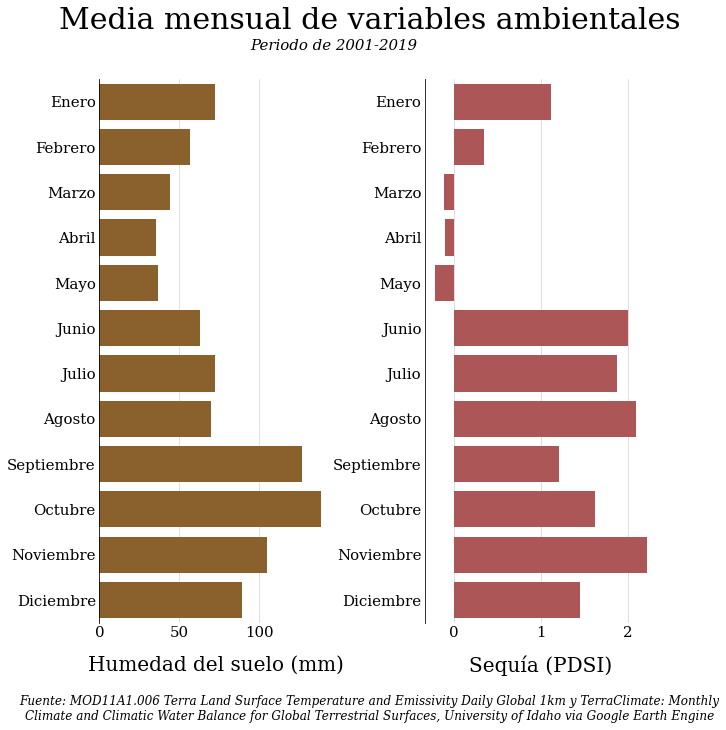

In [28]:
df_monthly_environment_groupedMonth = df_monthly_environment.groupby('Month').median().reset_index()
df_monthly_environment_groupedMonth['Month'] = df_monthly_environment_groupedMonth['Month'].astype('category')
fig,(ax1,ax2) = plt.subplots(ncols=2, nrows=1, figsize=(10,10),
#dpi=150
)
fig.subplots_adjust(wspace=0.4)

sns.barplot(data=df_monthly_environment_groupedMonth, y='Month', x='Humedad del suelo', ax=ax1,
color=List_palette_01[4]
)
sns.barplot(data=df_monthly_environment_groupedMonth, y='Month', x='pdsi', ax=ax2,
color=List_palette_01[6]
)


ax1.spines['top'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax2.spines['bottom'].set_visible(False)

ax1.tick_params(axis='both', which='both', length=0)
ax2.tick_params(axis='both', which='both', length=0)
ax1.grid(visible = True, color='silver', alpha=1, ls='solid', axis='x', lw=0.5)
ax2.grid(visible = True, color='silver', alpha=1, ls='solid', axis='x', lw=0.5)
ax1.set_axisbelow(True)
ax2.set_axisbelow(True)

ax1.set_yticklabels(['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'])
ax1.tick_params(labelsize=15)
ax1.set_ylabel('')
ax1.set_xlabel('Humedad del suelo (mm)', size=20, labelpad=15)
ax2.set_yticklabels(['Enero','Febrero','Marzo','Abril','Mayo','Junio','Julio','Agosto','Septiembre','Octubre','Noviembre','Diciembre'])
ax2.tick_params(labelsize=15)
ax2.set_ylabel('')
ax2.set_xlabel('Sequía (PDSI)', size=20, labelpad=15)

fig.suptitle('Media mensual de variables ambientales',size=30)
fig.text(x=0.45,y=0.92,s='Periodo de 2001-2019',fontdict=dict(size=15, style='italic'), ha='center')
caption = 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly\nClimate and Climatic Water Balance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine'
fig.text(x=0.5,y=-0.01,s=caption, fontdict=dict(size=12, style='italic'), ha='center')



> Se exportan los datos de la serie de tiempo `df_ts_temp_allMonths_allYears` para poder visualizarlos con **R**
>
```Python 
df_ts_temp_allMonths_allYears.to_csv('../datos/GEE/temperatura_yuc_modis_ee.csv', index=False)
```

Text(1, 0.99, 'Periodo de 2001-2019')

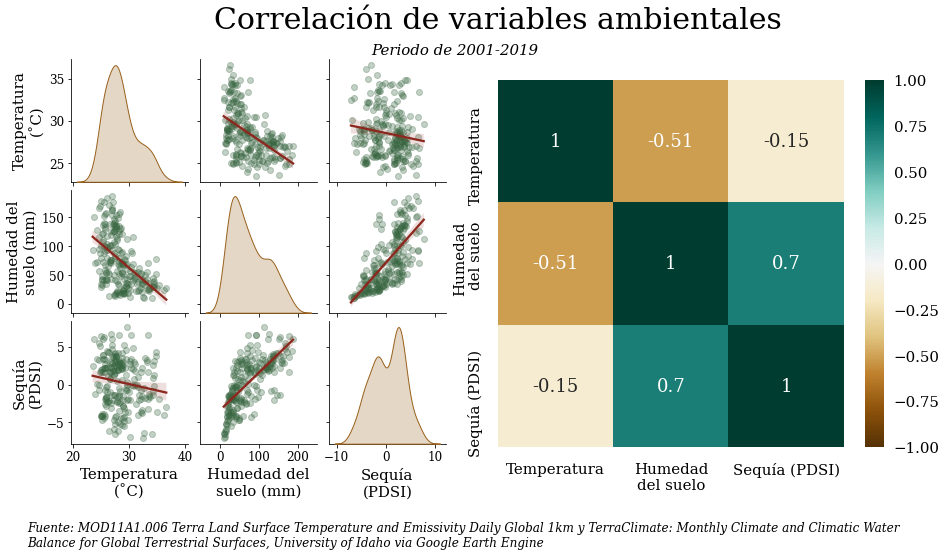

In [30]:
pairplot_environment = sns.pairplot(data=df_monthly_environment,
                                    x_vars = ['Temperatura','Humedad del suelo','pdsi'],
                                    y_vars = ['Temperatura','Humedad del suelo','pdsi'],
                                    height=2, aspect=1, kind='reg', diag_kind = 'kde',
                                    plot_kws = {'line_kws':{'color':List_palette_01[5]},
                                                'scatter_kws': {'color': List_palette_01[3],
                                                                'alpha':0.3
                                                                }
                                                },
                                    diag_kws = {'color':List_palette_01[4] }
                                    )


ax = pairplot_environment.fig.add_axes([1.1,0.08,1,0.85])
sns.heatmap(data=df_monthly_environment.iloc[:,:3].corr(),
            annot=True, vmin=-1,vmax=1, cmap='BrBG', ax=ax,
            annot_kws = dict(size=18),
            )
ax.set_xticklabels(['Temperatura', 'Humedad\ndel suelo', 'Sequía (PDSI)'])
ax.set_yticks(list(np.arange(3)+0.25))
ax.set_yticklabels(['Temperatura', 'Humedad\ndel suelo', 'Sequía (PDSI)'])
cbar = ax.collections[0].colorbar

pairplot_environment.fig.suptitle('Correlación de variables ambientales', y=1.1, x=1.1, size=30)
caption = 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly Climate and Climatic Water\nBalance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine'
pairplot_environment.fig.text(x=0.01,y=-0.15,s=caption, fontdict=dict(size=12, style='italic'))

pairplot_environment.axes[2,0].xaxis.set_label_text('Temperatura\n(˚C)',size=15)
pairplot_environment.axes[2,0].xaxis.set_tick_params(labelsize=12)
pairplot_environment.axes[2,1].xaxis.set_label_text('Humedad del\nsuelo (mm)',size=15)
pairplot_environment.axes[2,1].xaxis.set_tick_params(labelsize=12)
pairplot_environment.axes[2,2].xaxis.set_label_text('Sequía\n(PDSI)',size=15)
pairplot_environment.axes[2,2].xaxis.set_tick_params(labelsize=12)

pairplot_environment.axes[0,0].yaxis.set_label_text('Temperatura\n(˚C)',size=15)
pairplot_environment.axes[0,0].yaxis.set_tick_params(labelsize=12)
pairplot_environment.axes[1,0].yaxis.set_label_text('Humedad del\nsuelo (mm)',size=15)
pairplot_environment.axes[1,0].yaxis.set_tick_params(labelsize=12)
pairplot_environment.axes[2,0].yaxis.set_label_text('Sequía\n(PDSI)',size=15)
pairplot_environment.axes[2,0].yaxis.set_tick_params(labelsize=12)

ax.tick_params(axis='both', labelsize=15, pad=15, length=0)
cbar.ax.tick_params(axis='both', length=0, labelsize=15, pad=10)

pairplot_environment.fig.text(x=1,y=0.99,s='Periodo de 2001-2019',fontdict=dict(size=15, style='italic'), ha='center')


#pairplot_environment.fig.set_dpi(150)



Text(0.1, 0.1, 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly Climate and Climatic Water\nBalance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine')

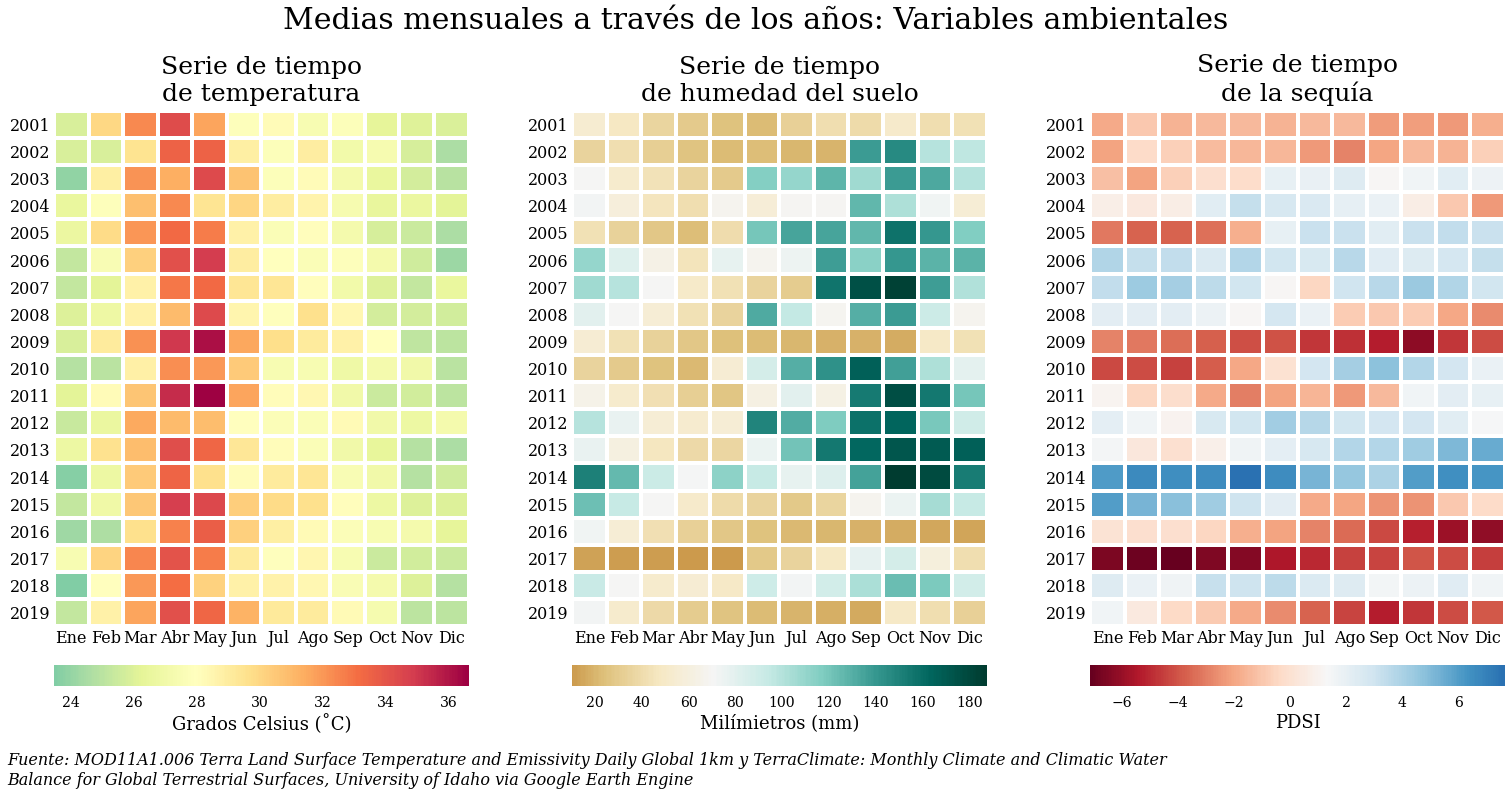

In [31]:
# pandas.DataFrame de cada variable ambiental
df_monthly_environment_temp = df_monthly_environment.pivot(index='Year', columns='Month', values='Temperatura')
df_monthly_environment_humedad = df_monthly_environment.pivot(index='Year', columns='Month', values='Humedad del suelo')
df_monthly_environment_sequia = df_monthly_environment.pivot(index='Year', columns='Month', values='pdsi')

# Maximos, mínimos y centros de los color map de los Heat maps
max_temp = df_monthly_environment_temp.max().max()
min_temp = df_monthly_environment_temp.min().min()
center_temp = df_monthly_environment_temp.median().median()

max_humedad = df_monthly_environment_humedad.max().max()
min_humedad = df_monthly_environment_humedad.min().min()
center_humedad = df_monthly_environment_humedad.median().median()

max_sequia = df_monthly_environment_sequia.max().max()
min_sequia = df_monthly_environment_sequia.min().min()
center_sequia = df_monthly_environment_sequia.median().median()

# Crear los plots
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3, nrows=1, figsize=(26,12),
#dpi=150
)
fig.subplots_adjust(wspace=0.25)

# Crear Heatmaps y color bars
sns.heatmap(data=df_monthly_environment_temp, ax=ax1,
xticklabels = ['Ene', 'Feb', 'Mar', 'Abr', 'May','Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic' ], 
lw=3, cmap='Spectral_r', center=center_temp, vmax=max_temp, vmin=min_temp,
cbar_kws = dict(orientation='horizontal', pad=0.06)
)
cbar_temp = ax1.collections[0].colorbar

sns.heatmap(data=df_monthly_environment_humedad, ax=ax2,
xticklabels = ['Ene', 'Feb', 'Mar', 'Abr', 'May','Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic' ], 
lw=3, cmap= 'BrBG', center= center_humedad, vmax = max_humedad, vmin = min_humedad,
cbar_kws = dict(orientation='horizontal', pad=0.06)
)
cbar_humedad = ax2.collections[0].colorbar


sns.heatmap(data=df_monthly_environment_sequia, ax=ax3,
xticklabels = ['Ene', 'Feb', 'Mar', 'Abr', 'May','Jun', 'Jul', 'Ago', 'Sep', 'Oct', 'Nov', 'Dic' ], 
lw=3, cmap= 'RdBu', center= center_sequia, vmax = max_sequia, vmin = min_sequia,
cbar_kws = dict(orientation='horizontal', pad=0.06)
)
cbar_sequia = ax3.collections[0].colorbar



fig.suptitle('Medias mensuales a través de los años: Variables ambientales', size=30,y=1.0)
ax1.set_title('Serie de tiempo\nde temperatura', size=25, pad=10)
ax2.set_title('Serie de tiempo\nde humedad del suelo', size=25, pad=10)
ax3.set_title('Serie de tiempo\nde la sequía', size=25, pad=10)
cbar_temp.set_label('Grados Celsius (˚C)', size=18)
cbar_humedad.set_label('Milímietros (mm)', size=18)
cbar_sequia.set_label('PDSI', size=18)


ax1.set_xlabel('')
ax1.set_ylabel('')
ax2.set_xlabel('')
ax2.set_ylabel('')
ax3.set_xlabel('')
ax3.set_ylabel('')
ax1.tick_params(axis='both', length=0, labelsize=16)
ax2.tick_params(axis='both', length=0, labelsize=16)
ax3.tick_params(axis='both', length=0, labelsize=16)
ax1.tick_params(axis='y', rotation=0)
ax2.tick_params(axis='y', rotation=0)
ax3.tick_params(axis='y', rotation=0)
cbar_temp.ax.tick_params(axis='both', length=0, labelsize=14, pad=10)
cbar_humedad.ax.tick_params(axis='both', length=0, labelsize=14, pad=10)
cbar_sequia.ax.tick_params(axis='both', length=0, labelsize=14, pad=10)

caption = 'Fuente: MOD11A1.006 Terra Land Surface Temperature and Emissivity Daily Global 1km y TerraClimate: Monthly Climate and Climatic Water\nBalance for Global Terrestrial Surfaces, University of Idaho via Google Earth Engine'
fig.text(x=0.1,y=0.1,s=caption, fontdict=dict(size=16, style='italic'))

Con la información mostrada se puede hacer un enfoque en las condiciones climáticas y las ocurrencias de fuego durante el trimestre de 
Marzo a Mayo en el periodo del 2001 al 2019

In [32]:
# Crear filtro de 3 meses de ventana
Filter_Trimestre = ee.Filter.calendarRange(3,5,'month')


ImgColl_Temp_trimestre = ImgColl_Temp.filter(Filter_Trimestre)
ImgColl_Humedad_trimestre = ImgColl_Humedad.filter(Filter_Trimestre)
ImgColl_Sequia_trimestre = ImgColl_Sequia.filter(Filter_Trimestre)
ImgColl_Fires_trimestre = ImgColl_Fires.filter(Filter_Trimestre)

In [33]:
# MAPA DE VARIABLES AMBIENTALES
# Crear mapa
Map_environment_02 = folium.Map(location=roi_centroid, zoom_start=8, zoom_control=True)

# Agregar capas a mapa
Map_environment_02.add_ee_layer(ee_image_object=ImgColl_Temp_trimestre.mean().clip(roi),
                            vis_params= VisParams_Temp,
                            name='Temperatura (˚C) media (2001-2020)')
Map_environment_02.add_ee_layer(ee_image_object=ImgColl_Humedad_trimestre.mean().clip(roi),
                            vis_params= VisParams_Hum,
                            name='Humedad media (mm) (2001-2020)')
Map_environment_02.add_ee_layer(ee_image_object=ImgColl_Sequia_trimestre.mean().clip(roi),
                            vis_params= VisParams_Seq,
                            name= 'Sequía (PDSI) media (2001-2020)')
Map_environment_02.add_ee_layer(ee_image_object=ImgColl_Fires_trimestre.mosaic().clip(roi),
                            vis_params= VisParams_Fires,
                            name='Incendios 2001-2019')

# Control de capas
Map_environment_02.add_child(folium.LayerControl())
# Visualizar mapa
Map_environment_02

## Índices de vegetación

In [34]:
# Base Line median NDVI 
Img_BaseLine_NDVI_median = ImgColl_NDVI.filterDate('2001-01-01','2003-12-31').median()
Img_BaseLine_EVI_median = ImgColl_EVI.filterDate('2001-01-01','2003-12-31').median()

# Recent data
ImgColl_Recent_NDVI = ImgColl_NDVI.filterDate('2004-01-01','2019-12-31')
ImgColl_Recent_EVI = ImgColl_EVI.filterDate('2004-01-01','2019-12-31')
Img_Recent_NDVI_median = ImgColl_NDVI.filterDate('2004-01-01','2019-12-31').median() #vis
Img_Recent_EVI_median = ImgColl_EVI.filterDate('2004-01-01','2019-12-31').median() # vis

# Resta de mediana
def resta_mediana_NDVI(image):
    return image.subtract(Img_BaseLine_NDVI_median).copyProperties(image,['system:time_start'])

def resta_mediana_EVI(image):
    return image.subtract(Img_BaseLine_EVI_median).copyProperties(image,['system:time_start'])

Anomalies_NDVI = ImgColl_Recent_NDVI.map(resta_mediana_NDVI)
Anomalies_EVI = ImgColl_Recent_EVI.map(resta_mediana_EVI)

In [35]:
# Visualization parameters
VisParams_NDVI = dict(min=-1,max=1,palette=List_palette_06_NDVI)
VisParams_EVI = dict(min=-1,max=1, palette=List_palette_07_EVI)
VisParams_Anomalies_VegIdx = dict(min=-0.5,max=0.5, palette=List_palette_08_Anomalies_VegIdx)

In [36]:
Mapa_VegIdx = folium.Map(location=roi_centroid, zoom_start=9, zoom_control=True)

Mapa_VegIdx.add_ee_layer(ee_image_object=Img_BaseLine_NDVI_median.clip(roi), vis_params= VisParams_NDVI, name= "Mediana NDVI. Periodo de 2001-2003")
Mapa_VegIdx.add_ee_layer(ee_image_object=Img_Recent_NDVI_median.clip(roi), vis_params= VisParams_NDVI, name= "Mediana NDVI. Periodo de 2004-2019")

Mapa_VegIdx.add_ee_layer(ee_image_object=Img_BaseLine_EVI_median.clip(roi), vis_params= VisParams_EVI, name= "Mediana EVI. Periodo de 2001-2003")
Mapa_VegIdx.add_ee_layer(ee_image_object=Img_Recent_EVI_median.clip(roi), vis_params= VisParams_EVI, name= "Mediana EVI. Periodo de 2004-2019")

Mapa_VegIdx.add_ee_layer(ee_image_object=Anomalies_NDVI.mean().clip(roi), vis_params= VisParams_Anomalies_VegIdx, name="Cambios en NDVI")
Mapa_VegIdx.add_ee_layer(ee_image_object=Anomalies_EVI.median().clip(roi), vis_params= VisParams_Anomalies_VegIdx, name= "Cambios en EVI")

# Control de capas
Mapa_VegIdx.add_child(folium.LayerControl())
# Visualizar mapa
Mapa_VegIdx

Alternativa con **`geemap`**:

```Python
Mapa_VegIdx = geemap.Map(center=roi_centroid, zoom=9,add_google_map = False)

Mapa_VegIdx.addLayer(ee_object=Img_BaseLine_NDVI_median, vis_params=VisParams_NDVI, name='Base line NDVI')
Mapa_VegIdx.addLayer(ee_object=Img_BaseLine_EVI_median, vis_params= VisParams_EVI, name= 'Base line EVI')
Mapa_VegIdx.addLayer(ee_object= Img_Recent_NDVI_median, vis_params = VisParams_NDVI, name='Recent line NDVI')
Mapa_VegIdx.addLayer(ee_object= Img_Recent_EVI_median, vis_params = VisParams_EVI, name='Recent line EVI')
Mapa_VegIdx.addLayer(ee_object= Anomalies_NDVI, vis_params = VisParams_Anomalies_VegIdx, name='Anomalie line NDVI')
Mapa_VegIdx.addLayer(ee_object= Anomalies_EVI, vis_params = VisParams_Anomalies_VegIdx, name='Anomalie line EVI')
Mapa_VegIdx.addLayer(ee_object=ImgColl_Fires.mosaic().clip(roi), vis_params= VisParams_Fires, name='Historial de incendios (2001-2019)')

"""Mapa_VegIdx.save('prov_mapas/Mapa_VegIdx.html')"""
Mapa_VegIdx
```

## Discusión: Abril 2017

> Se van a mostrar las siguientes variables para conocer la situación del estado en la fecha de Abril 2017:
>
> * Temperatura media y máxima de la superficie
> * PDSI media
> * Humedad de suelo media
> * Anomalías de EVI y NDVI (del mes pasado)
> * Polígonos representativos de las áreas afectadas
>
> Se calcula la mediana ya que es un estimador robusto a los datos anómalos

In [37]:
# ========================================== #
# Baseline (mes anterior: Marzo)
Img_BaseLine_NDVI_median = ImgColl_NDVI.filterDate('2017-03-01','2017-03-31').median()
Img_BaseLine_EVI_median = ImgColl_EVI.filterDate('2017-03-01','2017-03-31').median()
# Recent data (mes interés: Abril)
ImgColl_Recent_NDVI = ImgColl_NDVI.filterDate('2017-04-01','2017-04-30')
ImgColl_Recent_EVI = ImgColl_EVI.filterDate('2017-04-01','2017-04-30')

# Resta de mediana
def resta_mediana_NDVI(image):
    return image.subtract(Img_BaseLine_NDVI_median)
def resta_mediana_EVI(image):
    return image.subtract(Img_BaseLine_EVI_median)
# =========================================== #



# Juntar los puntos del mes de Abril
Img_Fires_abril_2017 = ImgColl_Fires.filterDate('2017-04-01','2017-04-30').mosaic().clip(roi)
Temp_median_abril_2017 = ImgColl_Temp.filterDate('2017-04-01','2017-04-30').median().clip(roi)
Temp_max_abril_2017 = ImgColl_Temp.filterDate('2017-04-01','2017-04-30').max().clip(roi)
PDSI_median_abril_2017 = ImgColl_Sequia.filterDate('2017-04-01','2017-04-30').median().clip(roi)
Humedad_median_abril_2017 = ImgColl_Humedad.filterDate('2017-04-01','2017-04-30').median().clip(roi)
Anomalies_NDVI_abril_2017 = ImgColl_Recent_NDVI.map(resta_mediana_NDVI).median().clip(roi)
Anomalies_EVI_abril_2017 = ImgColl_Recent_EVI.map(resta_mediana_EVI).median().clip(roi)

In [38]:
# Cargar datos de la CONAFOR y FIRMS
df_conafor = gpd.read_file('../datos/CONAFOR/datos_conafor_2017.geojson')
df_firms = gpd.read_file('../datos/NASA/datos_firms_2016_2018.geojson')
q3_confianza_value = df_firms['confidence'].quantile(0.75)
df_firms = df_firms[df_firms['confidence'] > q3_confianza_value]

# Limitar la fecha 
df_conafor['Fecha Inicio'] = pd.to_datetime(df_conafor['Fecha Inicio'])
df_conafor = df_conafor.set_index('Fecha Inicio')
df_conafor_abril = df_conafor.loc['2017-04']

df_firms['acq_date'] = pd.to_datetime(df_firms['acq_date'])
df_firms = df_firms.set_index('acq_date')
df_firms_abril = df_firms.loc['2017-04']

In [39]:
loc_conafor = np.array([[p.xy[1][0], p.xy[0][0]] for p in df_conafor_abril.geometry])
loc_firms = np.array([[p.xy[1][0], p.xy[0][0]] for p in df_firms_abril.geometry])

In [40]:
Mapa_Abril_2017 = folium.Map(location=roi_centroid, zoom_control=True, zoom_start=8)

# Se agregan los puntos a un mapa
# CONAFOR
for i in range(loc_conafor.shape[0]):
    folium.Circle(
        location = loc_conafor[i].tolist(),
        radius = 250, #m
        popup = f"Duración: {df_conafor['Duración días'].values[i]}",
        color = List_palette_01[3],
        fill=True,
        fill_color=List_palette_01[3]
    ).add_to(Mapa_Abril_2017)

# FIRMS
for i in range(loc_firms.shape[0]):
    folium.Circle(
        location = loc_firms[i].tolist(),
        radius = 250, #m
        popup = f"Confianza: {df_firms['confidence'].values[i]}%",
        color = List_palette_01[4],
        fill=True,
        fill_color=List_palette_01[4],
    ).add_to(Mapa_Abril_2017)


Mapa_Abril_2017.add_ee_layer(ee_image_object= Temp_median_abril_2017,
vis_params=VisParams_Temp, name='Temperatura mediana. Abril 2017')

Mapa_Abril_2017.add_ee_layer(ee_image_object=PDSI_median_abril_2017,
vis_params=VisParams_Seq, name='PSDI (mediana). Abril 2017')

Mapa_Abril_2017.add_ee_layer(ee_image_object=Humedad_median_abril_2017,
vis_params=VisParams_Hum, name='Humedad del suelo (mediana). Abril 2017')

Mapa_Abril_2017.add_ee_layer(ee_image_object=Anomalies_NDVI_abril_2017,
vis_params=VisParams_Anomalies_VegIdx, name='Cambios o anomalías en NDVI. Abril 2017')

Mapa_Abril_2017.add_ee_layer(ee_image_object=Anomalies_EVI_abril_2017,
vis_params=VisParams_Anomalies_VegIdx, name='Cambios o anomalías en EVI. Abril 2017')

Mapa_Abril_2017.add_ee_layer(ee_image_object=Img_Fires_abril_2017, 
vis_params= VisParams_Fires, name='Áreas afectadas en el mes de abril')

Mapa_Abril_2017.add_child(folium.LayerControl())
Mapa_Abril_2017.save('prov_mapas/Mapa_Abril_2017.html')
Mapa_Abril_2017